In [3]:
#imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import matplotlib as mpl

### Jobwise energy data

In [4]:
energy = pd.read_csv('/gpfs/alpine/stf218/proj-shared/data/lake.dev/summit_perhost_jobs_full/jobwise_combine.csv')


### Jobwise power data

In [5]:
files = glob.glob('/gpfs/alpine/stf218/proj-shared/data/lake/summit_power_temp_openbmc/power_jobwise_10s/*.csv')
temp_pwr = []
[temp_pwr.append(pd.read_csv(f,index_col=None)) for f in files]
power = pd.concat(temp_pwr, ignore_index=True)


In [6]:
energy_df = energy.loc[:,['allocation_id','energy','num_nodes','job_domain','job_time']]
energy_df['node_hours'] = (energy_df['num_nodes']*energy_df['job_time'])/3600
energy_df['job_minutes'] = energy_df['job_time']/60
energy_df['jobtime_in_hours'] = energy_df['job_time']/3600
power_df = power.loc[:,['allocation_id','max_sum_inp','max_sum_top','mean_sum_inp']]
power_energy = energy_df.merge(power_df)

### Classification by scheduling

In [7]:
job_node_cat = [(power_energy['num_nodes']<=45),
                (power_energy['num_nodes']>45)&(power_energy['num_nodes']<=91),
                (power_energy['num_nodes']>91)&(power_energy['num_nodes']<=921),
                (power_energy['num_nodes']>921)&(power_energy['num_nodes']<=2764),
                (power_energy['num_nodes']>2764)]


values = ['A-45','B-91','C-921','D-2764','E-4608']
power_energy['node_cat'] = np.select(job_node_cat,values)


In [8]:
job_node_class = [(power_energy['num_nodes']<=45),
                (power_energy['num_nodes']>45)&(power_energy['num_nodes']<=91),
                (power_energy['num_nodes']>91)&(power_energy['num_nodes']<=921),
                (power_energy['num_nodes']>921)&(power_energy['num_nodes']<=2764),
                (power_energy['num_nodes']>2764)]


class_values = [5,4,3,2,1]
power_energy['Class'] = np.select(job_node_class,class_values)

job_type = [(power_energy['node_cat']=='A-45')|(power_energy['node_cat']=='B-91')|(power_energy['node_cat']=='C-921'),
                (power_energy['node_cat']=='D-2764'),
                (power_energy['node_cat']=='E-4608')]


values = ['small','large','flagship']
power_energy['job_type'] = np.select(job_type,values)

In [ ]:
plot_df = power_energy[power_energy['energy']>=0]
plot_df['energy'] = plot_df['energy']+1
plot_df['max_sum_inp'] = plot_df['max_sum_inp']+1

In [ ]:
plot_df['log_energy'] = np.log(plot_df['energy'])
plot_df['log_max_sum_inp'] = np.log(plot_df['max_sum_inp'])
plot_df = plot_df[(plot_df['log_max_sum_inp'] > 0)&(plot_df['log_energy'] > 0)]

### Assign project domain

In [11]:
import csv


with open('/gpfs/alpine/stf218/proj-shared/25amk/domain_proj.csv', mode='r') as inp:
    reader = csv.reader(inp)
    dict_domain = {rows[0]:rows[1] for rows in reader}
plot_df['job_group'] = plot_df['job_domain'].map(dict_domain).fillna(plot_df['job_domain'])

### Plots

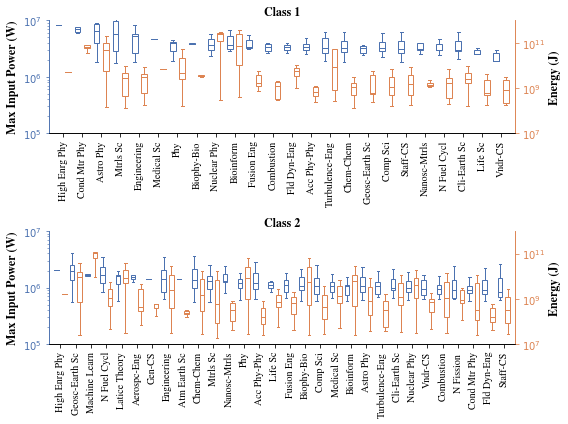

In [12]:

blue, orange = sns.color_palette('deep', n_colors=2)
DOUBLE_COLUMN = DOUBLE_WIDTH = 8.0
sns.set_context(rc = {'patch.linewidth': 0.0, 'axes.labelsize': 12, 'font.family': 'STIXGeneral'})


fig, axes = plt.subplots(nrows=2, ncols=1,
                         figsize=(DOUBLE_WIDTH, DOUBLE_WIDTH*3/4))
ann_text=['Class 1','Class 2']

large_left = axes[0]
flagship_left = axes[1]
for ec, sz in enumerate(['small','flagship','large']) :
    if sz == 'small':
        continue
    loop_df = plot_df[plot_df['job_type'] == sz]
    #sorting the bar plot based on median values
    dmn_list = list(loop_df.groupby('job_group')['max_sum_inp'].quantile([0.5]).sort_values(ascending=False).index.get_level_values(0))
    
    l=[]    
    for l1 in dmn_list:
        l.append(np.array(loop_df[loop_df['job_group'] == l1]['max_sum_inp']))
    m=[]    
    for l1 in dmn_list:
        m.append(np.array(loop_df[loop_df['job_group'] == l1]['energy']))
    len_bxplt = len(m)
    ax1 = axes[ec-1]   
    ax1.set_ylabel('Max Input Power (W)', fontweight='bold',fontfamily='STIXGeneral')
    
    res1 = ax1.boxplot(
        l, positions = np.arange(len_bxplt)-0.25, widths=0.3, sym='', meanline=True,
        patch_artist=True,showfliers=True, boxprops=dict(facecolor="C0"),
    )
    for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(res1[element], color=blue)
    
    for patch in res1['boxes']:
        patch.set_facecolor('None')
    
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    ax2.set_ylabel('Energy (J)', fontweight='bold',fontfamily='STIXGeneral')
    res2 = ax2.boxplot(
        m, positions = np.arange(len_bxplt)+0.25, widths=0.3, sym='', meanline=True,
        patch_artist=True,showfliers=True, boxprops=dict(facecolor="C1"),
    )
    for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(res2[element], color=orange)
    
    for patch in res2['boxes']:
        patch.set_facecolor('None')

    ax1.set_xticks(np.arange(len_bxplt))
    ax1.set_xticklabels(dmn_list,rotation=90,size=10,fontfamily='STIXGeneral')
    ax1.set_ylim(10**5,10**7)
    ax2.set_ylim(10**7,10**12)
    ax2.set_yscale('log')
    ax1.set_yscale('log')
    ax1.spines['left'].set_color(blue)
    ax2.spines['left'].set_color(blue)
    ax1.spines['right'].set_color(orange)
    ax2.spines['right'].set_color(orange)
    ax2.spines['top'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    ax1.tick_params(axis='y', colors=blue, which='both')
    ax2.tick_params(axis='y', colors=orange, which='both')

    ax1.annotate(ann_text[ec-1], xy=(0.5, 1), xytext=(0, 5),
                xycoords='axes fraction', textcoords='offset points',
                size='large', ha='center', va='baseline',
                  fontsize=12, fontweight='bold',fontfamily='STIXGeneral')
fig.tight_layout()
fig.savefig(f'../plots/energy_power_boxplot.pdf',format='pdf', bbox_inches='tight', pad_inches=0.0)

In [40]:
#Calculating the features for cdfs
max_inp_power_d = (np.sort(plot_df[plot_df['node_cat']=='E-4608']['max_sum_inp'].values))/10**6
mean_inp_power_d = (np.sort(plot_df[plot_df['node_cat']=='E-4608']['mean_sum_inp'].values))/10**6
job_minutes_d = np.sort(plot_df[plot_df['node_cat']=='E-4608']['job_minutes'].values)
job_hours_d = np.sort(plot_df[plot_df['node_cat']=='E-4608']['jobtime_in_hours'].values)
nodes_d = np.sort(plot_df[plot_df['node_cat']=='E-4608']['num_nodes'].values)
node_hours_d = np.sort(plot_df[plot_df['node_cat']=='E-4608']['node_hours'].values)
max_diff_mean_d = (np.sort(plot_df[plot_df['node_cat']=='E-4608']['max_sum_inp'].values - 
                          plot_df[plot_df['node_cat']=='E-4608']['mean_sum_inp'].values))/10**6

y_l_d = np.array( range(1,len(max_inp_power_d)+1))
y_l_d = (y_l_d - min(y_l_d)) / (max(y_l_d) - min(y_l_d)) * 100

max_inp_power = (np.sort(plot_df[plot_df['node_cat']=='D-2764']['max_sum_inp'].values))/10**6
mean_inp_power = (np.sort(plot_df[plot_df['node_cat']=='D-2764']['mean_sum_inp'].values))/10**6
job_minutes = np.sort(plot_df[plot_df['node_cat']=='D-2764']['job_minutes'].values)
job_hours = np.sort(plot_df[plot_df['node_cat']=='D-2764']['jobtime_in_hours'].values)
nodes = np.sort(plot_df[plot_df['node_cat']=='D-2764']['num_nodes'].values)
node_hours = np.sort(plot_df[plot_df['node_cat']=='D-2764']['node_hours'].values)
max_diff_mean = (np.sort(plot_df[plot_df['node_cat']=='D-2764']['max_sum_inp'].values - 
                        plot_df[plot_df['node_cat']=='D-2764']['mean_sum_inp'].values))/10**6

y_l=np.array( range(1,len(max_inp_power)+1))
y_l = (y_l - min(y_l)) / (max(y_l) - min(y_l)) * 100

### cdf plots for number of jobs

<Figure size 432x288 with 0 Axes>

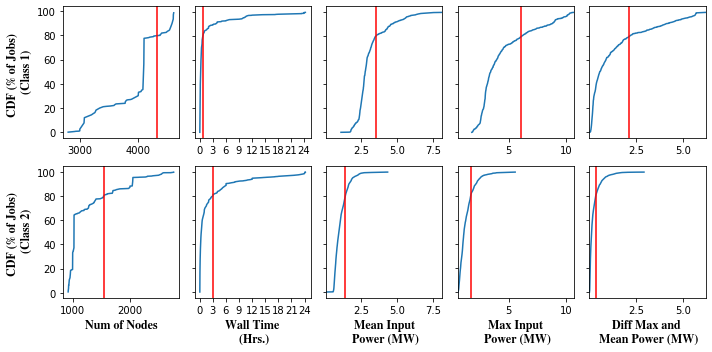

In [46]:
import matplotlib.ticker as ticker

SINGLE_COLUMN = SINGLE_WIDTH = 6.0
DOUBLE_COLUMN = DOUBLE_WIDTH = 10.0
WEIGHT_VAR='bold'
FONTSIZE_VAR=12
sns.set_context(rc = {'patch.linewidth': 0.0, 'axes.labelsize': 12, 'axes.labelweight':"normal"})
sns.despine(top=False, right=False)

fig, axes = plt.subplots(nrows=2, ncols=5, 
                         figsize=(DOUBLE_WIDTH, DOUBLE_WIDTH*3/6))

sns.lineplot(x=nodes_d, y=y_l_d, ax=axes[0,0])
axes[0,0].set_ylabel("CDF (% of Jobs) \n (Class 1)",fontweight=WEIGHT_VAR,
                     fontsize=FONTSIZE_VAR,fontfamily='STIXGeneral')
idx = int(np.argmax(y_l_d)*0.8)
axes[0,0].axvline(nodes_d[idx], color='red') 

sns.lineplot(x=job_hours_d, y=y_l_d, ax=axes[0,1])
axes[0,1].set_ylabel("")
axes[0,1].set_yticklabels([])
axes[0,1].axvline(job_hours_d[idx], color='red') 
axes[0,1].xaxis.set_major_locator(ticker.MultipleLocator(3))
axes[0,1].xaxis.set_major_formatter(ticker.ScalarFormatter())

sns.lineplot(x=mean_inp_power_d, y=y_l_d, ax=axes[0,2])
axes[0,2].set_ylabel("")
axes[0,2].set_yticklabels([])
axes[0,2].axvline(mean_inp_power_d[idx], color='red') 
axes[0,2].set_xlim((min(mean_inp_power)),(max(mean_inp_power_d)))

sns.lineplot(x=max_inp_power_d, y=y_l_d, ax=axes[0,3])
axes[0,3].set_ylabel("")
axes[0,3].set_yticklabels([])
axes[0,3].axvline(max_inp_power_d[idx], color='red') 
axes[0,3].set_xlim((min(max_inp_power)),(max(max_inp_power_d)))

sns.lineplot(x=max_diff_mean_d, y=y_l_d, ax=axes[0,4])
axes[0,4].set_ylabel("")
axes[0,4].set_yticklabels([])
axes[0,4].axvline(max_diff_mean_d[idx], color='red') 
axes[0,4].set_xlim((min(max_diff_mean)),(max(max_diff_mean_d)))

#Row 2
sns.lineplot(x=nodes, y=y_l, ax=axes[1,0])
axes[1,0].set_ylabel("CDF (% of Jobs) \n (Class 2)",fontweight=WEIGHT_VAR,
                     fontsize=FONTSIZE_VAR,fontfamily='STIXGeneral')
axes[1,0].set_xlabel('Num of Nodes',fontweight=WEIGHT_VAR,
                     fontsize=FONTSIZE_VAR,fontfamily='STIXGeneral')
idx = int(np.argmax(y_l)*0.8)
axes[1,0].axvline(nodes[idx], color='red') 
axes[1,1].xaxis.set_major_locator(ticker.MultipleLocator(3))
axes[1,1].xaxis.set_major_formatter(ticker.ScalarFormatter())

sns.lineplot(x=job_hours, y=y_l, ax=axes[1,1])
axes[1,1].set_ylabel("")
axes[1,1].set_yticklabels([])
axes[1,1].set_xlabel('Wall Time\n (Hrs.)',fontweight=WEIGHT_VAR,
                     fontsize=FONTSIZE_VAR,fontfamily='STIXGeneral')
axes[1,1].axvline(job_hours[idx], color='red') 
axes[1,1].xaxis.set_major_locator(ticker.MultipleLocator(3))
axes[1,1].xaxis.set_major_formatter(ticker.ScalarFormatter())

sns.lineplot(x=mean_inp_power, y=y_l, ax=axes[1,2])
axes[1,2].set_ylabel("")
axes[1,2].set_yticklabels([])
axes[1,2].set_xlabel('Mean Input\n Power (MW)',fontweight=WEIGHT_VAR,
                     fontsize=FONTSIZE_VAR,fontfamily='STIXGeneral')
axes[1,2].axvline(mean_inp_power[idx], color='red')
axes[1,2].set_xlim((min(mean_inp_power)),(max(mean_inp_power_d)))

sns.lineplot(x=max_inp_power, y=y_l, ax=axes[1,3])
axes[1,3].set_ylabel("")
axes[1,3].set_yticklabels([])
axes[1,3].set_xlabel('Max Input\n Power (MW)',fontweight=WEIGHT_VAR,
                     fontsize=FONTSIZE_VAR,fontfamily='STIXGeneral')
axes[1,3].axvline(max_inp_power[idx], color='red') 
axes[1,3].set_xlim((min(max_inp_power)),(max(max_inp_power_d)))

sns.lineplot(x=max_diff_mean, y=y_l, ax=axes[1,4])
axes[1,4].set_ylabel("")
axes[1,4].set_yticklabels([])
axes[1,4].set_xlabel('Diff Max and \n Mean Power (MW)',fontweight=WEIGHT_VAR,
                     fontsize=FONTSIZE_VAR,fontfamily='STIXGeneral')
axes[1,4].axvline(max_diff_mean[idx], color='red') 
axes[1,4].set_xlim((min(max_diff_mean)),(max(max_diff_mean_d)))

fig.tight_layout()

In [47]:
fig.savefig(f'../plots/jobs_cdf.pdf',format='pdf', bbox_inches='tight', pad_inches=0.0)